In [ ]:
! pip install datasets transformers
! pip install optuna
import transformers
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

import pandas as pd
import numpy as np
import datasets

from google.colab import drive
from datasets import load_metric
from huggingface_hub import notebook_login
from datasets import load_metric
from sklearn.model_selection import train_test_split
from datasets import Dataset

!apt install git-lfs

     |████████████████████████████████| 325 kB 4.1 MB/s 
     |████████████████████████████████| 4.0 MB 46.6 MB/s 
     |████████████████████████████████| 212 kB 49.0 MB/s 
     |████████████████████████████████| 1.1 MB 47.1 MB/s 
     |████████████████████████████████| 77 kB 5.6 MB/s 
     |████████████████████████████████| 136 kB 41.8 MB/s 
     |████████████████████████████████| 127 kB 52.6 MB/s 
     |████████████████████████████████| 6.5 MB 33.5 MB/s 
     |████████████████████████████████| 596 kB 52.3 MB/s 
     |████████████████████████████████| 895 kB 50.1 MB/s 
     |████████████████████████████████| 271 kB 43.9 MB/s 
     |████████████████████████████████| 94 kB 3.6 MB/s 
     |████████████████████████████████| 144 kB 38.5 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling

In [ ]:
notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
data_path = 'gdrive/MyDrive/THESIS/datasets'

In [ ]:
ethics_train = pd.read_csv(data_path+'/prepped_data/freeform/ethics_freeform_train.csv')
ethics_dev = pd.read_csv(data_path+'/prepped_data/freeform/ethics_freeform_dev.csv')
ethics_test = pd.read_csv(data_path+'/prepped_data/freeform/ethics_freeform_test.csv')

sbic_train = pd.read_csv(data_path+'/prepped_data/freeform/sbic_freeform_train.csv')
sbic_dev = pd.read_csv(data_path+'/prepped_data/freeform/sbic_freeform_dev.csv')
sbic_test = pd.read_csv(data_path+'/prepped_data/freeform/sbic_freeform_test.csv')

ms_train = pd.read_csv(data_path+'/prepped_data/freeform/moralstories_freeform_train.csv')
ms_dev = pd.read_csv(data_path+'/prepped_data/freeform/moralstories_freeform_dev.csv')
ms_test = pd.read_csv(data_path+'/prepped_data/freeform/moralstories_freeform_test.csv')

sc_train = pd.read_csv(data_path+'/prepped_data/freeform/socialchemistry_freeform_train.csv')
sc_dev = pd.read_csv(data_path+'/prepped_data/freeform/socialchemistry_freeform_dev.csv')
sc_test = pd.read_csv(data_path+'/prepped_data/freeform/socialchemistry_freeform_test.csv')

In [ ]:
ms_train.rename(columns={'judgement':'label', 'action_pairs':'input'}, inplace=True)
ms_train.drop(['situation', 'intention'], 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


,Unnamed: 0,input,label
0,3111,Dave tells Kevin that he is disgusting and th...,bad
1,18679,Homer sees an opening and quickly swerves thro...,bad
2,17472,"""Jay writes """"Good luck today"""" on the note an...",good
3,21451,Randy signs a mortgage on a home without telli...,bad
4,20800,Becky approaches her husband about his snoring...,good
...,...,...,...
14395,3988,Amanda uses her savings to buy the textbooks.,good
14396,4593,Gigi is too shy to ask people to take their sh...,bad
14397,713,Chad tells the woman that he's a doctor even t...,bad
14398,559,Dave tells Judy that he can see her boobs and ...,bad


In [ ]:
sbic_train.rename(columns={'intentYN':'label', 'post':'input'}, inplace=True)

In [ ]:
sc_train.rename(columns={'rot-judgment':'label', 'situation':'input'}, inplace=True)

In [ ]:
# we can merge the datasets now
# first reindex sc df, label should come first
columns_titles = ['rot-judgment', 'situation']
sc_train = sc_train.reindex(columns=columns_titles)

In [ ]:
columns_titles = ['label', 'input']
ms_train = ms_train.reindex(columns=columns_titles)

In [ ]:
all_train = [ethics_train, sbic_train, sc_train, ms_train] # leaving out ethics
train_merged = pd.concat(all_train)
train_merged.drop(columns=train_merged.columns[0], 
        axis=1, 
        inplace=True)

train_merged

,label,input,rot-judgment,situation
0,okay,I was cold so I started the heater.,NaN,NaN
1,not okay,I stayed in an Air BnB and left a turd in the ...,NaN,NaN
2,not okay,AITA for comparing and rating people around me...,NaN,NaN
3,not okay,AITA for going to a murder mystery night and h...,NaN,NaN
4,not okay,I licked the bottle before offering it to a fr...,NaN,NaN
...,...,...,...,...
14395,good,Amanda uses her savings to buy the textbooks.,NaN,NaN
14396,bad,Gigi is too shy to ask people to take their sh...,NaN,NaN
14397,bad,Chad tells the woman that he's a doctor even t...,NaN,NaN
14398,bad,Dave tells Judy that he can see her boobs and ...,NaN,NaN


In [ ]:
# for simplicity's sake...
train_merged = train_merged.drop('rot-judgment', 1)
train_merged = train_merged.drop('situation', 1)
train_merged

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


,label,input
0,okay,I was cold so I started the heater.
1,not okay,I stayed in an Air BnB and left a turd in the ...
2,not okay,AITA for comparing and rating people around me...
3,not okay,AITA for going to a murder mystery night and h...
4,not okay,I licked the bottle before offering it to a fr...
...,...,...
14395,good,Amanda uses her savings to buy the textbooks.
14396,bad,Gigi is too shy to ask people to take their sh...
14397,bad,Chad tells the woman that he's a doctor even t...
14398,bad,Dave tells Judy that he can see her boobs and ...


In [ ]:
train_merged.dropna(axis=0, inplace=True)
train_merged

,label,input
0,okay,I was cold so I started the heater.
1,not okay,I stayed in an Air BnB and left a turd in the ...
2,not okay,AITA for comparing and rating people around me...
3,not okay,AITA for going to a murder mystery night and h...
4,not okay,I licked the bottle before offering it to a fr...
...,...,...
14395,good,Amanda uses her savings to buy the textbooks.
14396,bad,Gigi is too shy to ask people to take their sh...
14397,bad,Chad tells the woman that he's a doctor even t...
14398,bad,Dave tells Judy that he can see her boobs and ...


In [ ]:
# do the same for dev sets
ms_dev.rename(columns={'judgement':'label', 'action_pairs':'input'}, inplace=True)
ms_dev.drop(['situation', 'intention'], 1, inplace=True)
sbic_dev.rename(columns={'intentYN':'label', 'post':'input'}, inplace=True)
sc_dev.rename(columns={'rot-judgment':'label', 'situation':'input'}, inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
columns_titles = ['label', 'input']
sc_dev = sc_dev.reindex(columns=columns_titles)

In [ ]:
columns_titles = ['label', 'input']
ms_dev = ms_dev.reindex(columns=columns_titles)

In [ ]:
all_dev = [ethics_train, sbic_dev, sc_dev, ms_dev]
dev_merged = pd.concat(all_dev)
dev_merged
dev_merged.drop(columns=dev_merged.columns[0], 
        axis=1, 
        inplace=True)

In [ ]:
dev_merged.dropna(axis=0, inplace=True)
dev_merged

,label,input
0,okay,I was cold so I started the heater.
1,not okay,I stayed in an Air BnB and left a turd in the ...
2,not okay,AITA for comparing and rating people around me...
3,not okay,AITA for going to a murder mystery night and h...
4,not okay,I licked the bottle before offering it to a fr...
...,...,...
4795,good,Jared invites a 22yr old woman to his home for...
4796,good,Finley replies to his mom's text messages lett...
4797,good,Marcus shares the results of his test on Faceb...
4798,good,Sharon invites all of her classmates to the pa...


In [ ]:
# and for test sets
ms_test.rename(columns={'judgement':'label', 'action_pairs':'input'}, inplace=True)
ms_test.drop(['situation', 'intention'], 1, inplace=True)
sbic_test.rename(columns={'intentYN':'label', 'post':'input'}, inplace=True)
sc_test.rename(columns={'rot-judgment':'label', 'situation':'input'}, inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
columns_titles = ['label', 'input']
sc_test = sc_test.reindex(columns=columns_titles)

In [ ]:
columns_titles = ['label', 'input']
ms_test = ms_test.reindex(columns=columns_titles)

In [ ]:
all_test = [ethics_train, sbic_test, sc_test, ms_test] # leaving out ethics
test_merged = pd.concat(all_test)
test_merged.drop(columns=test_merged.columns[0], 
        axis=1, 
        inplace=True)

In [ ]:
test_merged.dropna(axis=0, inplace=True)
test_merged

,label,input
0,okay,I was cold so I started the heater.
1,not okay,I stayed in an Air BnB and left a turd in the ...
2,not okay,AITA for comparing and rating people around me...
3,not okay,AITA for going to a murder mystery night and h...
4,not okay,I licked the bottle before offering it to a fr...
...,...,...
4795,bad,Frank asks questions personal questions about ...
4796,good,Sam tells Bill he doesn't know how to rock cli...
4797,good,Chad stomps on the brake so that the raccoon c...
4798,bad,Kara decides to keep the watch that she finds ...


In [ ]:
# now some preprocessing: inputs should be tokenized and labels should be numeric 
# also, all three splits should combine into a DatasetDict (so the keys are train, test and validation, and their values are one dataset each with the columns and data etc)

In [ ]:
all_dfs = [train_merged, dev_merged, test_merged]
df = pd.concat(all_dfs)

In [ ]:
type(train_merged) 
# we have now merged three pandas dataframes into one pandas dataframe

pandas.core.frame.DataFrame

In [ ]:
# all labels in this df should be in the same case
df["label"] = df["label"].str.lower()

In [ ]:
pd.set_option("display.max_rows", None)

In [ ]:
# need to replace all labels with either 'okay' or 'not okay'. let's only do the ones that occur more than 100 times in the dataset (delete the rest)
df['label'].value_counts()

it's offensive                                                                     77696
it's okay                                                                          65684
it's good                                                                          13822
good                                                                               13438
bad                                                                                12346
okay                                                                               12054
not okay                                                                            9693
should                                                                              7082
it's wrong                                                                          6144
shouldn't                                                                           5808
you should                                                                          5460
it's understandable  

In [ ]:
# replacing the negative labels with "not okay"
df['label'].replace(dict.fromkeys(["it's offensive", "bad", "not okay", "it's wrong", "shouldn't", "you shouldn't", "it's bad", "it's rude", "it's not okay", "it is wrong", "it is bad", "it is rude", "wrong", "should not", "rude", "it's hurtful", "you can't", "it's mean", "can't", "shouldnt", 'is wrong', "shouldn't", "it's frowned upon", "it's frustrating", "its wrong", "you don't have to", "it's inappropriate", "it's normal"], 'not okay'), inplace=True)


In [ ]:
# replacing the positive labels with "okay"
df['label'].replace(dict.fromkeys(['okay',"it's okay",'good','expected', "it's good", "it's understandable", "it's reasonable", "should", "it's fine", "you should", "it's expected", "it is good", "expected", "it is okay", "it's ok", "it's important", "it is expected", "it's nice", "understandable", "it's acceptable", "it's fun", "it's allowed", "its good", "ok", "you should always", "it is normal", "it is understandable", "it's kind", "it's encouraged", "it is important", "is expected", "it is reasonable", "it's reasonable", "its okay", "normal", "is good", "it's understood", "important", "it's good to", "it's polite", "people should", "is okay", "it is nice", "it's smart", "allowed", "are expected", "its expected", "should always", "it's wise", "you're expected", "you are expected", "it is acceptable", "fine", "it's good.", "it's common"], 'okay'), inplace=True)


In [ ]:
df['label'].value_counts()

okay                                                                               147878
not okay                                                                           132261
{}                                                                                   2048
it's okay to                                                                           96
you're allowed                                                                         94
its understandable                                                                     92
acceptable                                                                             92
it's unacceptable                                                                      90
should.                                                                                90
it's admirable                                                                         88
it's immoral                                                                           84
it's not g

In [ ]:
# deleting rows that have labels with valuecount under 100
counts = df['label'].value_counts()

df = df[~df['label'].isin(counts[counts < 100].index)]

In [ ]:
df['label'].value_counts()

okay        147878
not okay    132261
{}            2048
Name: label, dtype: int64

In [ ]:
# deleting rows with {} (dont know why its even there)
df = df[df.label != '{}']

In [ ]:
df['label'].value_counts()

okay        147878
not okay    132261
Name: label, dtype: int64

In [ ]:
# adding encoded label column: 1 is  okay, 0 is not okay
check = ['okay']
df['labels'] = df['label'].isin(check).astype(int)

In [ ]:
df.head()

,label,input,labels
0,okay,I was cold so I started the heater.,1
1,not okay,I stayed in an Air BnB and left a turd in the ...,0
2,not okay,AITA for comparing and rating people around me...,0
3,not okay,AITA for going to a murder mystery night and h...,0
4,not okay,I licked the bottle before offering it to a fr...,0


In [ ]:
df = df.drop('label', 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


In [ ]:
df.rename(columns={'input': 'sentence', 'labels': 'label'}, inplace=True)

In [ ]:
# there are memory problems. some sentences in input column are very long/multiple sentences. lets find average input length, and get rid of very long inputs (outliers)
# print(df[input].str.len().mean())

In [ ]:
df.shape

(280139, 2)

In [ ]:
df['string_length'] = df['sentence'].str.len()

In [ ]:
df.head()

,sentence,label,string_length
0,I was cold so I started the heater.,1,35
1,I stayed in an Air BnB and left a turd in the ...,0,56
2,AITA for comparing and rating people around me...,0,1116
3,AITA for going to a murder mystery night and h...,0,1080
4,I licked the bottle before offering it to a fr...,0,51


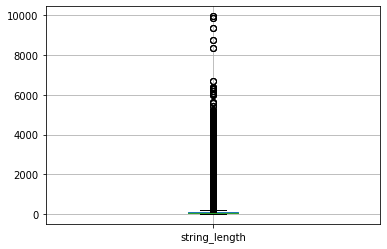

In [ ]:
df.boxplot(column='string_length'); # very many outliers!!!! these might be causing the memory issues. lets look closer

In [ ]:
df['string_length'].describe()

count    280139.000000
mean        154.167338
std         405.435326
min           2.000000
25%          49.000000
50%          71.000000
75%         112.000000
max        9946.000000
Name: string_length, dtype: float64

In [ ]:
cols = ['string_length']

Q1 = df[cols].quantile(0.25)
Q3 = df[cols].quantile(0.75)
IQR = Q3 - Q1

df = df[~((df[cols] < (Q1 - 1.5 * IQR)) |(df[cols] > (Q3 + 1.5 * IQR))).any(axis=1)]

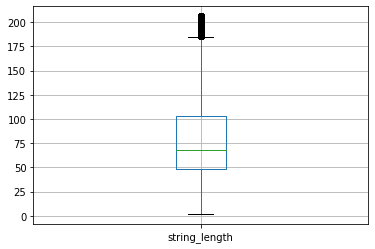

In [ ]:
df.boxplot(column='string_length');

In [ ]:
df.shape # we lost about 18 000 datapoints

(262652, 3)

In [ ]:
df = df.drop('string_length', 1) # dont need that column anymore

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


In [ ]:
df.head()

,sentence,label
0,I was cold so I started the heater.,1
1,I stayed in an Air BnB and left a turd in the ...,0
4,I licked the bottle before offering it to a fr...,0
9,I memorized the road rules so I could pass and...,1
15,I gave the dog's leash a yank to let my dog kn...,1


In [ ]:
# cuda out of memory keeps happening when trying to train. lets try taking out a huge chunk of the dataset

In [ ]:
df.shape

(262652, 2)

In [ ]:
delete_this = df.sample(frac=.4)
delete_this.shape

(105061, 2)

In [ ]:
df = df.drop(delete_this.index)

In [ ]:
df.shape # df is much smaller now

(56836, 2)

In [ ]:
train, test = train_test_split(df, test_size=0.2)

In [ ]:
dev, test = train_test_split(test, test_size=0.5)

In [ ]:
train.shape

(45468, 2)

In [ ]:
test.shape

(5684, 2)

In [ ]:
dev.shape

(5684, 2)

In [ ]:
type(train)
# again, this are three pandas dataframes. they should be converted to datasets before merging into datasetdict

pandas.core.frame.DataFrame

In [ ]:
train_dataset = Dataset.from_pandas(train)
dev_dataset = Dataset.from_pandas(dev)
test_dataset = Dataset.from_pandas(test)

In [ ]:
type(train_dataset)
# theyre datasets now! now make them a datasetdict

datasets.arrow_dataset.Dataset

In [ ]:
train_dataset

Dataset({
    features: ['sentence', 'label', '__index_level_0__'],
    num_rows: 45468
})

In [ ]:
dd = datasets.DatasetDict({"train":train_dataset,"validation":dev_dataset, "test":test_dataset})

In [ ]:
dd["train"][101]

{'__index_level_0__': 82221,
 'label': 0,
 'sentence': 'Trump is Moses parting the red sea of liberal communist illuminati globalist satanic scum'}

In [ ]:
# now lets do the tokenization
model_checkpoint = 'roberta-base'
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

In [ ]:
def preprocess_function(data):
    return tokenizer(data['sentence'], padding=True, truncation=True)

In [ ]:
data_encoded = dd.map(preprocess_function, batched=True) # this tokenizes the sentences

  0%|          | 0/46 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

In [ ]:
type(data_encoded)

datasets.dataset_dict.DatasetDict

In [ ]:
# now finetune the model

In [ ]:
num_labels = len(pd.unique(df['label']))

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)

Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifi

In [ ]:
args = TrainingArguments(
    'thesis-freeform',
    evaluation_strategy = 'epoch',
    save_strategy = 'epoch',
    learning_rate = 1e-4,
    per_device_train_batch_size = 8,
    per_device_eval_batch_size = 8, # trainer works up to batch size 8 with the smaller df. size 4 with larger df doesnt work.
    num_train_epochs = 4,
    weight_decay = 0.01,
    load_best_model_at_end = True,
    metric_for_best_model = 'accuracy',
    push_to_hub = True)

In [ ]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = predictions[:, 0]
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset=data_encoded['train'],
    eval_dataset=data_encoded['validation'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics)

Cloning https://huggingface.co/maretamasaeva/thesis-freeform into local empty directory.


In [ ]:
metric = load_metric('accuracy')

In [ ]:
trainer.train() 

The following columns in the training set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence. If __index_level_0__, sentence are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 45468
  Num Epochs = 4
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 22736


Epoch,Training Loss,Validation Loss,Accuracy
1,0.692200,0.692777,0.463582
2,0.694600,0.691785,0.463582
3,0.692000,0.694892,0.463582
4,0.690100,0.693270,0.463582


The following columns in the evaluation set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence. If __index_level_0__, sentence are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 5684
  Batch size = 8
Saving model checkpoint to thesis-freeform/checkpoint-5684
Configuration saved in thesis-freeform/checkpoint-5684/config.json
Model weights saved in thesis-freeform/checkpoint-5684/pytorch_model.bin
tokenizer config file saved in thesis-freeform/checkpoint-5684/tokenizer_config.json
Special tokens file saved in thesis-freeform/checkpoint-5684/special_tokens_map.json
tokenizer config file saved in thesis-freeform/tokenizer_config.json
Special tokens file saved in thesis-freeform/special_tokens_map.json
The following columns in the evaluation set  don't have a corresponding argument in `RobertaForSequenceClassific

TrainOutput(global_step=22736, training_loss=0.6937303865232742, metrics={'train_runtime': 7671.3558, 'train_samples_per_second': 23.708, 'train_steps_per_second': 2.964, 'total_flos': 8439911989428480.0, 'train_loss': 0.6937303865232742, 'epoch': 4.0})

In [ ]:
trainer.push_to_hub() # pushing the model to hub after hyperparameter search as well (?)
# pushing already because CUDA goes out of memory if i first tune hyperparameters. better save already, then i can load model in other notebook and tune it there, hopefully.

Saving model checkpoint to thesis-freeform
Configuration saved in thesis-freeform/config.json
Model weights saved in thesis-freeform/pytorch_model.bin
tokenizer config file saved in thesis-freeform/tokenizer_config.json
Special tokens file saved in thesis-freeform/special_tokens_map.json
Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file runs/Apr11_07-33-41_10315de1a0e2/events.out.tfevents.1649662443.10315de1a0e2.77.0:  28%|##8       …

To https://huggingface.co/maretamasaeva/thesis-freeform
   39931cd..f678ac2  main -> main

Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Text Classification', 'type': 'text-classification'}, 'metrics': [{'name': 'Accuracy', 'type': 'accuracy', 'value': 0.46358198451794513}]}
To https://huggingface.co/maretamasaeva/thesis-freeform
   f678ac2..ece4535  main -> main



'https://huggingface.co/maretamasaeva/thesis-freeform/commit/f678ac2a2e4c4bbbe72788cace03a1648315093b'

Everything under this cell was when I tried to tune hyperparameters in this notebook as well, but then I ran into CUDA issues. So I decided to just save the model and tune in other notebook (thesis-freeform-hptuning). This was omitted eventually because the SVM model performed better. 

In [ ]:
! pip install optuna
# ! pip install ray[tune]

In [ ]:
def model_init():
    return AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)

In [ ]:
# !nvidia-smi

In [ ]:
# device = 'cuda'
# import torch, gc
# import os
# gc.collect()
# torch.cuda.empty_cache()

In [ ]:
args = TrainingArguments(
    'thesis-freeform-hptuned',
    evaluation_strategy = 'epoch',
    save_strategy = 'epoch',
    learning_rate = 1e-4,
    per_device_train_batch_size = 8,
    per_device_eval_batch_size = 8, # trainer works up to batch size 8 with the smaller df. size 4 with larger df doesnt work. this results in about .44 accuracy i think? only on freeform data tho. 
    num_train_epochs = 4,
    weight_decay = 0.01,
    load_best_model_at_end = True,
    metric_for_best_model = 'accuracy',
    push_to_hub = True)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [ ]:
trainer = Trainer(
    model_init=model_init,
    args=args,
    train_dataset=data_encoded['train'].shard(index=1, num_shards=10), # finding best hyperparameters for 1/10 of dataset. takes too long otherwise. (also cuda will go out of memory again)
    eval_dataset=data_encoded['validation'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics)

loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.18.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

loading weights file https://huggingface.co/roberta-base/r

In [ ]:
# finding best hyperparameters for 1/10 of dataset. takes too long otherwise. 
# train_dataset = data_encoded["train"].shard(index=1, num_shards=10)  

In [ ]:
best_run = trainer.hyperparameter_search(n_trials=10, direction="maximize")

[I 2022-04-11 09:42:46,018] A new study created in memory with name: no-name-55968563-0f11-4c61-85e3-bef8898975a7
Trial:
loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.18.0",
  "type

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.566546,0.463582


The following columns in the evaluation set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence. If __index_level_0__, sentence are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 5684
  Batch size = 8
Saving model checkpoint to thesis-freeform-hptuned/run-0/checkpoint-72
Configuration saved in thesis-freeform-hptuned/run-0/checkpoint-72/config.json
Model weights saved in thesis-freeform-hptuned/run-0/checkpoint-72/pytorch_model.bin
tokenizer config file saved in thesis-freeform-hptuned/run-0/checkpoint-72/tokenizer_config.json
Special tokens file saved in thesis-freeform-hptuned/run-0/checkpoint-72/special_tokens_map.json
tokenizer config file saved in thesis-freeform-hptuned/tokenizer_config.json
Special tokens file saved in thesis-freeform-hptuned/special_tokens_map.json


Training completed. Do not forget 

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.679522,0.463582
2,No log,0.664833,0.463582


The following columns in the evaluation set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence. If __index_level_0__, sentence are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 5684
  Batch size = 8
Saving model checkpoint to thesis-freeform-hptuned/run-1/checkpoint-72
Configuration saved in thesis-freeform-hptuned/run-1/checkpoint-72/config.json
Model weights saved in thesis-freeform-hptuned/run-1/checkpoint-72/pytorch_model.bin
tokenizer config file saved in thesis-freeform-hptuned/run-1/checkpoint-72/tokenizer_config.json
Special tokens file saved in thesis-freeform-hptuned/run-1/checkpoint-72/special_tokens_map.json
The following columns in the evaluation set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence. If __index_

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.693512,0.463582
2,No log,0.685001,0.463582
3,No log,0.681237,0.463582


The following columns in the evaluation set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence. If __index_level_0__, sentence are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 5684
  Batch size = 8
Saving model checkpoint to thesis-freeform-hptuned/run-2/checkpoint-72
Configuration saved in thesis-freeform-hptuned/run-2/checkpoint-72/config.json
Model weights saved in thesis-freeform-hptuned/run-2/checkpoint-72/pytorch_model.bin
tokenizer config file saved in thesis-freeform-hptuned/run-2/checkpoint-72/tokenizer_config.json
Special tokens file saved in thesis-freeform-hptuned/run-2/checkpoint-72/special_tokens_map.json
The following columns in the evaluation set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence. If __index_

Epoch,Training Loss,Validation Loss,Accuracy
1,0.593800,0.464829,0.266362
2,0.589900,0.764018,0.067030
3,0.467500,1.000242,0.028325
4,0.333700,1.041646,0.022343
5,0.258600,1.128172,0.018649


The following columns in the evaluation set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence. If __index_level_0__, sentence are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 5684
  Batch size = 8
Saving model checkpoint to thesis-freeform-hptuned/run-3/checkpoint-1137
Configuration saved in thesis-freeform-hptuned/run-3/checkpoint-1137/config.json
Model weights saved in thesis-freeform-hptuned/run-3/checkpoint-1137/pytorch_model.bin
tokenizer config file saved in thesis-freeform-hptuned/run-3/checkpoint-1137/tokenizer_config.json
Special tokens file saved in thesis-freeform-hptuned/run-3/checkpoint-1137/special_tokens_map.json
The following columns in the evaluation set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence. I

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.491638,0.236981
2,No log,0.472329,0.194757
3,No log,0.481956,0.161506
4,No log,0.496414,0.146728


The following columns in the evaluation set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence. If __index_level_0__, sentence are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 5684
  Batch size = 8
Saving model checkpoint to thesis-freeform-hptuned/run-4/checkpoint-72
Configuration saved in thesis-freeform-hptuned/run-4/checkpoint-72/config.json
Model weights saved in thesis-freeform-hptuned/run-4/checkpoint-72/pytorch_model.bin
tokenizer config file saved in thesis-freeform-hptuned/run-4/checkpoint-72/tokenizer_config.json
Special tokens file saved in thesis-freeform-hptuned/run-4/checkpoint-72/special_tokens_map.json
The following columns in the evaluation set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence. If __index_

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.656394,0.463582
2,No log,0.523742,0.403413
3,No log,0.509924,0.368403


The following columns in the evaluation set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence. If __index_level_0__, sentence are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 5684
  Batch size = 8
Saving model checkpoint to thesis-freeform-hptuned/run-5/checkpoint-143
Configuration saved in thesis-freeform-hptuned/run-5/checkpoint-143/config.json
Model weights saved in thesis-freeform-hptuned/run-5/checkpoint-143/pytorch_model.bin
tokenizer config file saved in thesis-freeform-hptuned/run-5/checkpoint-143/tokenizer_config.json
Special tokens file saved in thesis-freeform-hptuned/run-5/checkpoint-143/special_tokens_map.json
The following columns in the evaluation set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence. If __i

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.460782,0.326707


The following columns in the evaluation set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence. If __index_level_0__, sentence are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 5684
  Batch size = 8
[I 2022-04-11 10:56:47,130] Trial 6 pruned. 
Trial:
loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.652926,0.463582


The following columns in the evaluation set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence. If __index_level_0__, sentence are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 5684
  Batch size = 8
Saving model checkpoint to thesis-freeform-hptuned/run-7/checkpoint-285
Configuration saved in thesis-freeform-hptuned/run-7/checkpoint-285/config.json
Model weights saved in thesis-freeform-hptuned/run-7/checkpoint-285/pytorch_model.bin
tokenizer config file saved in thesis-freeform-hptuned/run-7/checkpoint-285/tokenizer_config.json
Special tokens file saved in thesis-freeform-hptuned/run-7/checkpoint-285/special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from thesis-freeform-hptuned/run-7/checkpoint-285 (score: 0.46358198451794513).


Epoch,Training Loss,Validation Loss,Accuracy
1,0.606300,0.532952,0.262491


The following columns in the evaluation set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence. If __index_level_0__, sentence are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 5684
  Batch size = 8
[I 2022-04-11 11:04:36,860] Trial 8 pruned. 
Trial:
loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.688749,0.463582
2,No log,0.686689,0.463582
3,No log,0.684744,0.463582


The following columns in the evaluation set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence. If __index_level_0__, sentence are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 5684
  Batch size = 8
Saving model checkpoint to thesis-freeform-hptuned/run-9/checkpoint-72
Configuration saved in thesis-freeform-hptuned/run-9/checkpoint-72/config.json
Model weights saved in thesis-freeform-hptuned/run-9/checkpoint-72/pytorch_model.bin
tokenizer config file saved in thesis-freeform-hptuned/run-9/checkpoint-72/tokenizer_config.json
Special tokens file saved in thesis-freeform-hptuned/run-9/checkpoint-72/special_tokens_map.json
The following columns in the evaluation set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence. If __index_

RuntimeError: ignored

In [ ]:
# this object contains the best hyperparameters (no difference in accuracy from original)
best_run